In [1]:
import torch
import torch.nn as nn
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# from arff2pandas import a2p
import scipy.io.arff as arff 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

(500, 141)
(4500, 141)
(5000, 141)
       att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138  

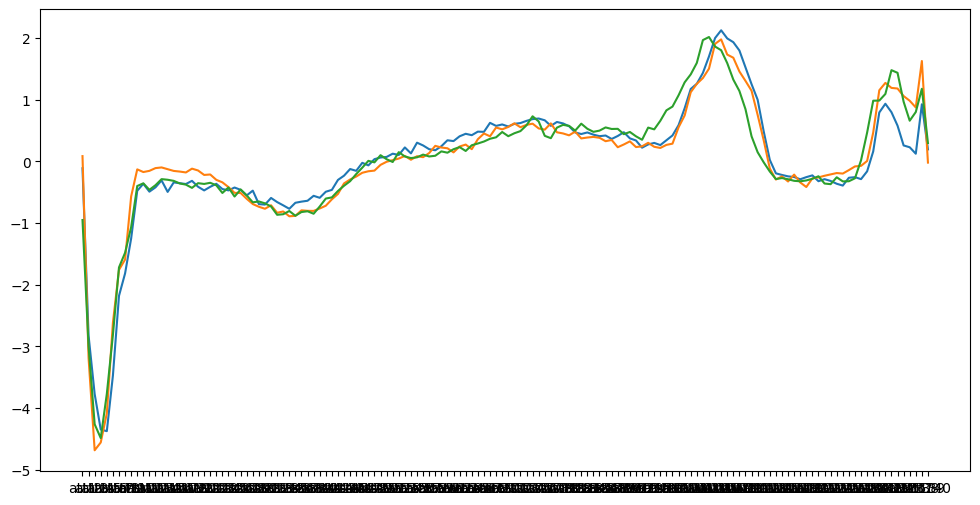

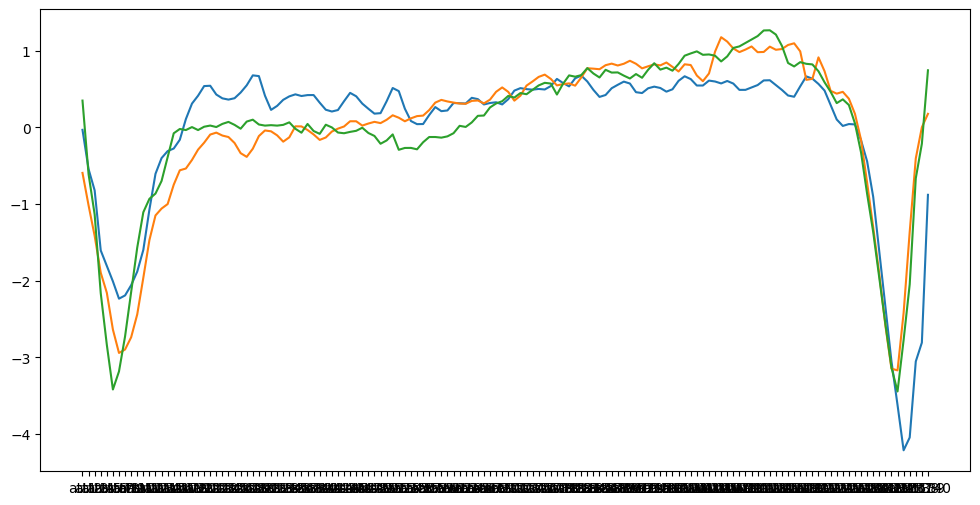

(2919, 141)
(2081, 141)


In [2]:
trainset_file = '/kaggle/input/ecg50000/ECG5000_TRAIN.arff'
testset_file = '/kaggle/input/ecg50000/ECG5000_TEST.arff'

traindata, trainmeta = arff.loadarff(trainset_file)
testdata, testmeta = arff.loadarff(testset_file)
train = pd.DataFrame(traindata, columns=trainmeta.names())
test = pd.DataFrame(testdata, columns=testmeta.names())
# df = train.append(test)
df = pd.concat([train, test])

print(train.shape)
print(test.shape)
print(df.shape)

print(df.head())

fig = plt.figure(figsize=(12, 6))

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df_norm = df[df.target == b'1']
df_abnorm = df[df.target != b'1']

plt.plot(df_norm.iloc[0, :-1])
plt.plot(df_norm.iloc[10, :-1])
plt.plot(df_norm.iloc[200, :-1])

plt.show()

fig = plt.figure(figsize=(12, 6))

plt.plot(df_abnorm.iloc[0, :-1])
plt.plot(df_abnorm.iloc[10, :-1])
plt.plot(df_abnorm.iloc[200, :-1])

plt.show()


print(df_norm.shape)
print(df_abnorm.shape)

In [3]:
class ECG5000(Dataset):

    def __init__(self, mode):

        assert mode in ['normal', 'anomaly']

        trainset_file = '/kaggle/input/ecg50000/ECG5000_TRAIN.arff'
        testset_file = '/kaggle/input/ecg50000/ECG5000_TEST.arff'

        traindata, trainmeta = arff.loadarff(trainset_file)
        testdata, testmeta = arff.loadarff(testset_file)
        train = pd.DataFrame(traindata, columns=trainmeta.names())
        test = pd.DataFrame(testdata, columns=testmeta.names())
        # df = train.append(test)
        df = pd.concat([train, test])

        # split in normal and anomaly data, then drop label
        CLASS_NORMAL = 1
        new_columns = list(df.columns)
        new_columns[-1] = 'target'
        df.columns = new_columns


        if mode == 'normal':
            df = df[df.target == b'1'].drop(labels='target', axis=1)
        else:
            df = df[df.target != b'1'].drop(labels='target', axis=1)

        print(df.shape)
        # train_df, val_df = train_test_split(
        #     normal_df,
        #     test_size=0.15,
        #     random_state=random_seed
        # )
        #
        # val_df, test_df = train_test_split(
        #     val_df,
        #     test_size=0.33,
        #     random_state=random_seed
        # )

        self.X = df.astype(np.float32).to_numpy()

    def get_torch_tensor(self):
        return torch.from_numpy(self.X)

    def __getitem__(self, index):
        return torch.from_numpy(self.X[index]).reshape(-1, 1)

    # return len of dataset
    def __len__(self):
        return self.X.shape[0]

In [4]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        batch_size = x.shape[0]
        # print(f'ENCODER input dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.n_features))
        # print(f'ENCODER reshaped dim: {x.shape}')
        x, (_, _) = self.rnn1(x)
        # print(f'ENCODER output rnn1 dim: {x.shape}')
        x, (hidden_n, _) = self.rnn2(x)
        # print(f'ENCODER output rnn2 dim: {x.shape}')
        # print(f'ENCODER hidden_n rnn2 dim: {hidden_n.shape}')
        # print(f'ENCODER hidden_n wants to be reshaped to : {(batch_size, self.embedding_dim)}')
        return hidden_n.reshape((batch_size, self.embedding_dim))

In [5]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        batch_size = x.shape[0]
        # print(f'DECODER input dim: {x.shape}')
        x = x.repeat(self.seq_len, self.n_features) # todo testare se funziona con più feature
        # print(f'DECODER repeat dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.input_dim))
        # print(f'DECODER reshaped dim: {x.shape}')
        x, (hidden_n, cell_n) = self.rnn1(x)
        # print(f'DECODER output rnn1 dim:/ {x.shape}')
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        return self.output_layer(x)


In [6]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64, device='cuda', batch_size=32):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
dataset_normal = ECG5000(mode='normal')
dataset_anomaly = ECG5000(mode='anomaly')

print(f'Normal dataset: {len(dataset_normal.X)}'
        f'Anomaly dataset: {len(dataset_anomaly.X)}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len, n_features = 140, 1
batch_size = 512

################################
validation_split = test_split = 0.15
random_seed = 42

(2919, 140)
(2081, 140)
Normal dataset: 2919Anomaly dataset: 2081


In [8]:
# Creating data indices for training and validation splits:
dataset_size = len(dataset_normal)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
print(f'dataset_size: {dataset_size}')
print(f'split: {split}')

dataset_size: 2919
split: 437


In [9]:
# suffling
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_indices, val_indices = train_indices[split:], train_indices[:split]

print('train_indices: ', len(train_indices))
print('val_indices: ', len(val_indices))
print('test_indices: ', len(test_indices))

train_indices:  2045
val_indices:  437
test_indices:  437


In [10]:
# check all splits have no intersections
assert not [value for value in train_indices if value in test_indices]
assert not [value for value in train_indices if value in val_indices]
assert not [value for value in val_indices if value in test_indices]

In [11]:
model = RecurrentAutoencoder(seq_len, n_features=n_features, embedding_dim=128, device=device, batch_size=batch_size)

In [12]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset_normal, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset_normal, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset_normal, batch_size=batch_size, sampler=test_sampler)
anomaly_loader = torch.utils.data.DataLoader(dataset_anomaly, batch_size=batch_size)


In [13]:
# start training
n_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='mean').to(device) # todo article use L1Loss
history = dict(train=[], val=[])
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0

for epoch in tqdm(range(1, n_epochs + 1)):
    model = model.train()

    train_losses = []
    val_losses = []
    test_losses = []
    anomaly_losses = []

    for i, seq_true in enumerate(train_loader):
        optimizer.zero_grad()
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model = model.eval()
    with torch.no_grad():

        # validation steps
        for i, seq_true in enumerate(validation_loader):
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

        # normal_test steps
        for i, seq_true in enumerate(test_loader):
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            test_losses.append(loss.item())

        # anomaly_test steps
        for i, seq_true in enumerate(anomaly_loader):
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            anomaly_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    test_loss = np.mean(test_losses)
    anomaly_loss = np.mean(anomaly_losses)
    history['train'].append(train_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: train loss {train_loss} {" "*6} val loss {val_loss} {" "*6} test loss {test_loss} {" "*6} anomaly loss {anomaly_loss}')
    # print(f'Epoch {epoch}: train loss {train_loss} {" "*6} val loss {val_loss} {" "*6} test loss {test_loss} {" "*6} anomaly loss {anomaly_loss}')

model.load_state_dict(best_model_wts)

  2%|▏         | 10/500 [00:09<07:21,  1.11it/s]

Epoch 10: train loss 0.8844058215618134        val loss 0.8708957433700562        test loss 0.8710586428642273        anomaly loss 0.9075164556503296


  4%|▍         | 20/500 [00:18<07:12,  1.11it/s]

Epoch 20: train loss 0.49110639095306396        val loss 0.49931085109710693        test loss 0.4959198236465454        anomaly loss 0.8253990650177002


  6%|▌         | 30/500 [00:27<07:03,  1.11it/s]

Epoch 30: train loss 0.47808368504047394        val loss 0.4773940443992615        test loss 0.4742971360683441        anomaly loss 0.8174909949302673


  8%|▊         | 40/500 [00:36<06:56,  1.10it/s]

Epoch 40: train loss 0.49185575544834137        val loss 0.4950960874557495        test loss 0.4898436963558197        anomaly loss 0.8215911507606506


 10%|█         | 50/500 [00:45<06:45,  1.11it/s]

Epoch 50: train loss 0.3719822019338608        val loss 0.3643316924571991        test loss 0.3679584562778473        anomaly loss 0.9520977973937989


 12%|█▏        | 60/500 [00:54<06:35,  1.11it/s]

Epoch 60: train loss 0.3488233685493469        val loss 0.350845068693161        test loss 0.35418954491615295        anomaly loss 0.9558016777038574


 14%|█▍        | 70/500 [01:03<06:26,  1.11it/s]

Epoch 70: train loss 0.35482967644929886        val loss 0.352985680103302        test loss 0.35589513182640076        anomaly loss 0.9544507026672363


 16%|█▌        | 80/500 [01:12<06:18,  1.11it/s]

Epoch 80: train loss 0.3441944494843483        val loss 0.34660014510154724        test loss 0.3491244316101074        anomaly loss 0.9630372762680054


 18%|█▊        | 90/500 [01:21<06:08,  1.11it/s]

Epoch 90: train loss 0.35194745659828186        val loss 0.35149645805358887        test loss 0.3546619117259979        anomaly loss 0.9559900164604187


 20%|██        | 100/500 [01:30<06:00,  1.11it/s]

Epoch 100: train loss 0.3440075144171715        val loss 0.34662261605262756        test loss 0.34923872351646423        anomaly loss 0.9632198691368103


 22%|██▏       | 110/500 [01:39<05:56,  1.09it/s]

Epoch 110: train loss 0.3432779386639595        val loss 0.3457556664943695        test loss 0.3482571542263031        anomaly loss 0.9689768195152283


 24%|██▍       | 120/500 [01:48<05:42,  1.11it/s]

Epoch 120: train loss 0.34318847209215164        val loss 0.3457082509994507        test loss 0.348188579082489        anomaly loss 0.9657021164894104


 26%|██▌       | 130/500 [01:57<05:35,  1.10it/s]

Epoch 130: train loss 0.34311097115278244        val loss 0.34551355242729187        test loss 0.3480025827884674        anomaly loss 0.9653308272361756


 28%|██▊       | 140/500 [02:06<05:25,  1.11it/s]

Epoch 140: train loss 0.3431800901889801        val loss 0.3454919755458832        test loss 0.3479834198951721        anomaly loss 0.9690950751304627


 30%|███       | 150/500 [02:15<05:16,  1.10it/s]

Epoch 150: train loss 0.34308793395757675        val loss 0.3456275165081024        test loss 0.3480200171470642        anomaly loss 0.9687429428100586


 32%|███▏      | 160/500 [02:24<05:05,  1.11it/s]

Epoch 160: train loss 0.34321868419647217        val loss 0.34535765647888184        test loss 0.3477790653705597        anomaly loss 0.9685921430587768


 34%|███▍      | 170/500 [02:33<04:58,  1.11it/s]

Epoch 170: train loss 0.34265486896038055        val loss 0.3451557755470276        test loss 0.34731587767601013        anomaly loss 0.9644822478294373


 36%|███▌      | 180/500 [02:43<04:55,  1.08it/s]

Epoch 180: train loss 0.3417179733514786        val loss 0.3448146879673004        test loss 0.34677979350090027        anomaly loss 0.9331200122833252


 38%|███▊      | 190/500 [02:52<04:39,  1.11it/s]

Epoch 190: train loss 0.34374093264341354        val loss 0.3457137942314148        test loss 0.34834495186805725        anomaly loss 0.9767117977142334


 40%|████      | 200/500 [03:01<04:30,  1.11it/s]

Epoch 200: train loss 0.3428838923573494        val loss 0.34536129236221313        test loss 0.34769386053085327        anomaly loss 0.9689761400222778


 42%|████▏     | 210/500 [03:10<04:22,  1.11it/s]

Epoch 210: train loss 0.3428281769156456        val loss 0.3453689515590668        test loss 0.34791919589042664        anomaly loss 0.9692906498908996


 44%|████▍     | 220/500 [03:19<04:13,  1.10it/s]

Epoch 220: train loss 0.3429330065846443        val loss 0.34529149532318115        test loss 0.34764713048934937        anomaly loss 0.967998743057251


 46%|████▌     | 230/500 [03:28<04:04,  1.10it/s]

Epoch 230: train loss 0.3427579328417778        val loss 0.34516483545303345        test loss 0.34751924872398376        anomaly loss 0.970850157737732


 48%|████▊     | 240/500 [03:37<03:55,  1.11it/s]

Epoch 240: train loss 0.3427697494626045        val loss 0.3452207148075104        test loss 0.34745264053344727        anomaly loss 0.9669903755187989


 50%|█████     | 250/500 [03:46<03:56,  1.05it/s]

Epoch 250: train loss 0.3427281528711319        val loss 0.3452041745185852        test loss 0.3475917875766754        anomaly loss 0.9692554831504822


 52%|█████▏    | 260/500 [03:55<03:36,  1.11it/s]

Epoch 260: train loss 0.3428104519844055        val loss 0.34533989429473877        test loss 0.34769123792648315        anomaly loss 0.9697811007499695


 54%|█████▍    | 270/500 [04:04<03:27,  1.11it/s]

Epoch 270: train loss 0.34277377277612686        val loss 0.345442533493042        test loss 0.3478648364543915        anomaly loss 0.9695360898971558


 56%|█████▌    | 280/500 [04:13<03:18,  1.11it/s]

Epoch 280: train loss 0.34311848878860474        val loss 0.34522292017936707        test loss 0.34760117530822754        anomaly loss 0.9724482536315918


 58%|█████▊    | 290/500 [04:22<03:09,  1.11it/s]

Epoch 290: train loss 0.34258031845092773        val loss 0.34486111998558044        test loss 0.34723591804504395        anomaly loss 0.9698761701583862


 60%|██████    | 300/500 [04:31<03:00,  1.11it/s]

Epoch 300: train loss 0.3425494134426117        val loss 0.34527522325515747        test loss 0.3474194407463074        anomaly loss 0.968350088596344


 62%|██████▏   | 310/500 [04:40<02:51,  1.11it/s]

Epoch 310: train loss 0.34250355511903763        val loss 0.34500521421432495        test loss 0.34740689396858215        anomaly loss 0.9735661149024963


 64%|██████▍   | 320/500 [04:49<02:42,  1.11it/s]

Epoch 320: train loss 0.34247589111328125        val loss 0.3448098301887512        test loss 0.3470610976219177        anomaly loss 0.9690977334976196


 66%|██████▌   | 330/500 [04:58<02:33,  1.11it/s]

Epoch 330: train loss 0.3425654321908951        val loss 0.3448733985424042        test loss 0.3470228314399719        anomaly loss 0.9694208264350891


 68%|██████▊   | 340/500 [05:07<02:24,  1.11it/s]

Epoch 340: train loss 0.34264739602804184        val loss 0.34542521834373474        test loss 0.3475479185581207        anomaly loss 0.9700355648994445


 70%|███████   | 350/500 [05:16<02:15,  1.11it/s]

Epoch 350: train loss 0.34236475080251694        val loss 0.34499311447143555        test loss 0.34711194038391113        anomaly loss 0.9698330998420716


 72%|███████▏  | 360/500 [05:25<02:06,  1.11it/s]

Epoch 360: train loss 0.3424248769879341        val loss 0.3448784649372101        test loss 0.3473310172557831        anomaly loss 0.9708550453186036


 74%|███████▍  | 370/500 [05:34<01:57,  1.11it/s]

Epoch 370: train loss 0.342411607503891        val loss 0.34476277232170105        test loss 0.3470174968242645        anomaly loss 0.9697009444236755


 76%|███████▌  | 380/500 [05:43<01:47,  1.11it/s]

Epoch 380: train loss 0.34182362258434296        val loss 0.3447323739528656        test loss 0.34716519713401794        anomaly loss 0.9736043572425842


 78%|███████▊  | 390/500 [05:52<01:39,  1.11it/s]

Epoch 390: train loss 0.3421907052397728        val loss 0.34446895122528076        test loss 0.3467850685119629        anomaly loss 0.9684662580490112


 80%|████████  | 400/500 [06:02<01:30,  1.11it/s]

Epoch 400: train loss 0.34237246960401535        val loss 0.3456593453884125        test loss 0.34752562642097473        anomaly loss 0.9730268239974975


 82%|████████▏ | 410/500 [06:11<01:20,  1.11it/s]

Epoch 410: train loss 0.3421311005949974        val loss 0.3444370925426483        test loss 0.3466724157333374        anomaly loss 0.9691934823989868


 84%|████████▍ | 420/500 [06:20<01:11,  1.11it/s]

Epoch 420: train loss 0.3423338979482651        val loss 0.3449525237083435        test loss 0.3470381200313568        anomaly loss 0.9630425691604614


 86%|████████▌ | 430/500 [06:29<01:03,  1.11it/s]

Epoch 430: train loss 0.3422151654958725        val loss 0.3447139263153076        test loss 0.3469336926937103        anomaly loss 0.9697512269020081


 88%|████████▊ | 440/500 [06:38<00:53,  1.11it/s]

Epoch 440: train loss 0.3419012576341629        val loss 0.3446491062641144        test loss 0.34684082865715027        anomaly loss 0.9708136200904847


 90%|█████████ | 450/500 [06:47<00:45,  1.11it/s]

Epoch 450: train loss 0.34214775264263153        val loss 0.34426841139793396        test loss 0.3463669419288635        anomaly loss 0.9690034747123718


 92%|█████████▏| 460/500 [06:56<00:36,  1.11it/s]

Epoch 460: train loss 0.34201333671808243        val loss 0.34432458877563477        test loss 0.346380352973938        anomaly loss 0.9678356766700744


 94%|█████████▍| 470/500 [07:05<00:27,  1.11it/s]

Epoch 470: train loss 0.3419192284345627        val loss 0.34402379393577576        test loss 0.3460604250431061        anomaly loss 0.9620212078094482


 96%|█████████▌| 480/500 [07:14<00:18,  1.10it/s]

Epoch 480: train loss 0.34030114859342575        val loss 0.3422711491584778        test loss 0.34423181414604187        anomaly loss 0.9678223848342895


 98%|█████████▊| 490/500 [07:23<00:09,  1.11it/s]

Epoch 490: train loss 0.3479698374867439        val loss 0.34553062915802        test loss 0.3473370373249054        anomaly loss 0.9653106808662415


100%|██████████| 500/500 [07:32<00:00,  1.11it/s]

Epoch 500: train loss 0.32549746334552765        val loss 0.31849443912506104        test loss 0.319945752620697        anomaly loss 0.9021648526191711


<All keys matched successfully>